In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib

params = {'legend.fontsize': 15,
          'figure.figsize': (7, 7),
          'axes.labelsize': 20,
          'axes.titlesize': 20,
          'axes.linewidth': 3,
          'xtick.labelsize':18,
          'ytick.labelsize':18,
          'xtick.labelsize':18,
          'ytick.labelsize':18,
          'svg.fonttype':'none'}
plt.rcParams.update(params)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
# === Set hyperparameters ===
epochs = 1000
batch_size = 32
learning_rate = 1e-4
dropout_prob = 0.3
latent_dim = 10
hidden_dim = 512
use_batchnorm = False
kl_anneal_epochs = epochs // 10 if epochs <= 1000 else 100
beta_max = 1.0
patience = 20
grad_clip_value = 1.0
# === Set random seed for reproducibility ===
torch.manual_seed(2025)
np.random.seed(2025)

In [3]:
# === Load and normalize your data ===
gene_df = pd.read_table("ko_table.tsv", index_col=0)
gene_df.columns.name = 'KO'
gene_df = gene_df.div(gene_df.sum(axis=1), axis=0)
# For demonstration:
# gene_df = pd.DataFrame(np.random.rand(100, 5000))

In [4]:
scaler = StandardScaler()
gene_df_scaled = scaler.fit_transform(gene_df)
data_tensor = torch.tensor(gene_df_scaled, dtype=torch.float32).to(device)
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [5]:
# === VAE with Dropout and Normalization ===
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, latent_dim=10, dropout_prob=0.2, use_batchnorm=True):
        super(VAE, self).__init__()
        self.use_batchnorm = use_batchnorm

        # Encoder
        self.encoder_fc = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()

        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.decoder_fc2 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        x = self.encoder_fc(x)
        x = self.bn1(x) if self.use_batchnorm else self.ln1(x)
        x = self.relu(x)
        x = self.dropout(x)
        return self.mu_layer(x), self.logvar_layer(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_fc1(z)
        z = self.bn2(z) if self.use_batchnorm else self.ln2(z)
        z = self.relu(z)
        z = self.dropout(z)
        return self.decoder_fc2(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# === Loss Function with KL Annealing ===
def loss_function(recon_x, x, mu, logvar, kl_weight):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_weight * kl_loss, recon_loss.item(), kl_loss.item()

# === Train the model ===
def train_vae(model, dataloader, optimizer, device, epochs=100, beta_max=1.0, kl_anneal_epochs=50, grad_clip_value=1.0, patience=20):
    model.train()
    loss_history = []
    recon_history = []
    kl_history = []
    best_loss = float("inf")
    counter = 0

    for epoch in range(epochs):
        total_loss = 0
        total_recon = 0
        total_kl = 0

        # Linearly anneal beta from 0 to beta_max
        beta = beta_max * min(1.0, epoch / kl_anneal_epochs)

        for batch in dataloader:
            batch = batch[0].to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar = model(batch)

            recon_loss = F.mse_loss(x_recon, batch, reduction="sum") / batch.size(0)
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch.size(0)

            # Optional: Add small latent regularization to prevent collapse
            latent_l1 = torch.mean(torch.abs(mu))
            latent_penalty = 1e-3 * latent_l1

            loss = recon_loss + beta * kl_div + latent_penalty
            loss.backward()

            # Gradient clipping
            if grad_clip_value is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value)

            optimizer.step()

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_div.item()

        avg_loss = total_loss / len(dataloader)
        avg_recon = total_recon / len(dataloader)
        avg_kl = total_kl / len(dataloader)

        loss_history.append(avg_loss)
        recon_history.append(avg_recon)
        kl_history.append(avg_kl)

        print(
            f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f} | Beta: {beta:.4f}"
        )

        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    history = {
        "epoch": list(range(1, len(loss_history) + 1)),
        "loss": loss_history,
        "reconstruction_loss": recon_history,
        "kl_divergence": kl_history,
    }

    return model, history

In [6]:
# # === Model Setup ===
# input_dim = gene_df.shape[1]
# vae = VAE(input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, dropout_prob=dropout_prob, use_batchnorm=use_batchnorm).to(device)
# optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# # === Train the model ===
# vae, history = train_vae(vae, dataloader, optimizer, device, epochs=epochs, kl_anneal_epochs=kl_anneal_epochs, grad_clip_value=grad_clip_value, patience=patience)

# # === Save the model and scaler ===
# torch.save(vae.state_dict(), "vae_model_rel.pth")
# joblib.dump(scaler, "scaler_rel.pkl")

In [7]:
# === load the model and scaler ===
input_dim = gene_df.shape[1]
vae = VAE(input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, dropout_prob=dropout_prob, use_batchnorm=use_batchnorm).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
vae.load_state_dict(torch.load("vae_model_rel.pth"))
scaler = joblib.load("scaler_rel.pkl")

/tmp/ipykernel_28101/2963233002.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("vae_model_rel.pth"))


# VAE Evaluation

In [8]:
# === Extract Latent Representations & Reconstructions ===
vae.eval()
with torch.no_grad():
    # full data
    recon_all, mu_all, logvar_all = vae(data_tensor)
    latent_repr = mu_all.numpy()          # shape: (n_samples, latent_dim)
    latent_repr_df = pd.DataFrame(latent_repr, columns=[f"latent_{i}" for i in range(latent_dim)], index=gene_df.index)
    reconstructed = recon_all.numpy()     # scaled-space reconstruction
    # inverse transform back to original scale
    reconstructed_orig = scaler.inverse_transform(reconstructed)
    reconstructed_df = pd.DataFrame(reconstructed_orig, columns=gene_df.columns, index=gene_df.index)

In [9]:
alpha_diversity = pd.read_table("alpha_diversity_genes.tsv", index_col=0)
alpha_diversity

,h0,h1,h2
sample_id,,,
SRS8422867,4274.0,1352.593293,970.926665
SRS8422868,3199.0,1386.403987,1000.136772
SRS8422869,3207.0,1378.247501,976.773418
SRS8422870,3169.0,1381.906235,985.215004
SRS8422871,3317.0,1234.780078,876.612034
...,...,...,...
ERS5127010,4276.0,1374.590396,985.951237
ERS5127011,4186.0,1374.236007,986.796128
ERS5127012,4148.0,1364.561829,979.065347


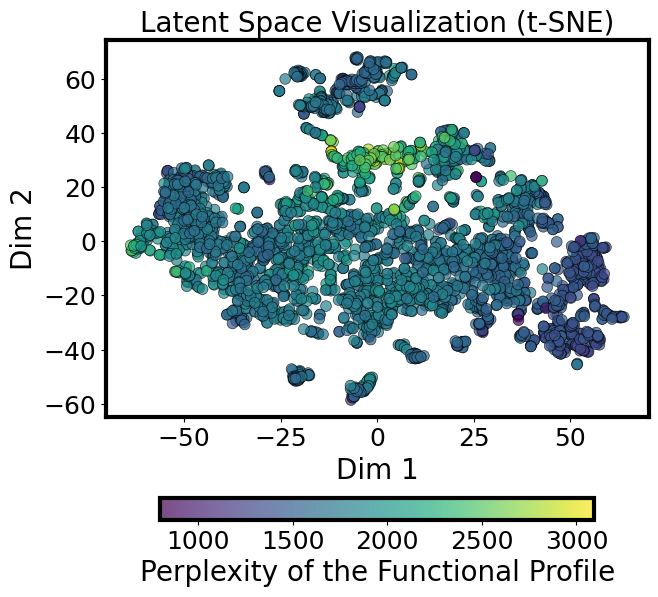

In [10]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# If latent_repr is (n_samples, latent_dim)
tsne = TSNE(n_components=2, perplexity=30)
z_tsne = tsne.fit_transform(latent_repr)

# plt.scatter(z_tsne[:, 0], z_tsne[:, 1], alpha=0.7)
# color by alpha diversity
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=alpha_diversity['h1'], cmap='viridis', alpha=0.7, edgecolor='k', s=60, linewidth=0.5)
# === Visualize the latent space using t-SNE ===
plt.colorbar(label='Perplexity of the Functional Profile', orientation='horizontal', shrink=0.8)
plt.title("Latent Space Visualization (t-SNE)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.savefig("latent_space_tsne.png", dpi=300, bbox_inches='tight')
plt.show()


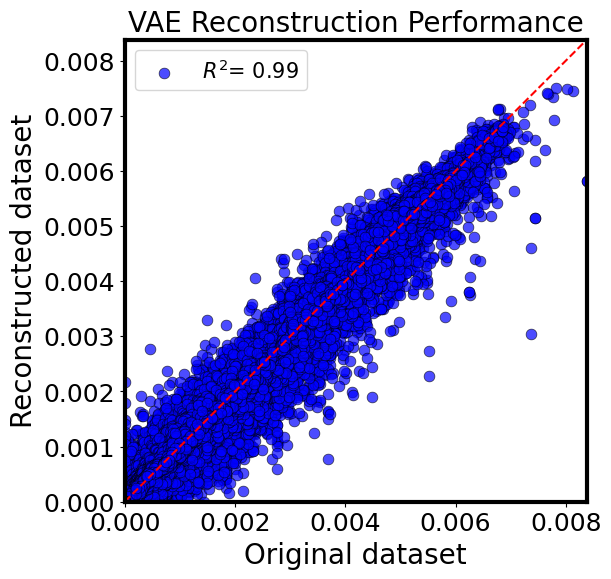

In [11]:
# Assessing reconstruction quality via pearson r
from scipy.stats import pearsonr
import seaborn as sns
def pearson_r(x, y):
    return pearsonr(x, y)[0]
# Compute Pearson correlation for each gene
pearson_results = []
for i in range(reconstructed_orig.shape[0]):
    r = pearson_r(gene_df.iloc[i, :], reconstructed_orig[i, :])**2
    pearson_results.append(r)
# Create a DataFrame for results
pearson_df = pd.DataFrame({
    'sample_id': gene_df.index,
    'Pearson_R': pearson_results
})
pearson_df = pearson_df.sort_values(by='Pearson_R', ascending=False)
# Plot scatter plot of original vs reconstructed
plt.figure(figsize=(8, 6))
plt.scatter(gene_df.values.flatten(), reconstructed_orig.flatten(), alpha=0.7, c='blue', edgecolors='k', s=60, linewidth=0.5)
plt.title("VAE Reconstruction Performance")
plt.xlabel("Original dataset")
plt.ylabel("Reconstructed dataset")
plt.plot([gene_df.values.min(), gene_df.values.max()], [gene_df.values.min(), gene_df.values.max()], 'r--')
plt.xlim(gene_df.values.min(), gene_df.values.max())
plt.ylim(gene_df.values.min(), gene_df.values.max())
plt.gca().set_aspect('equal', adjustable='box')
plt.legend([f'$R^2$= {pearson_df['Pearson_R'].mean():.2f}'], loc='upper left')
plt.savefig("reconstruction_performance.png", dpi=300, bbox_inches='tight')
plt.show()
# Plot histogram of Pearson R
# plt.figure(figsize=(8, 6))
# sns.histplot(pearson_df['Pearson_R'], bins=30)
# plt.title("Histogram of Pearson R")
# plt.xlabel("Pearson R")
# plt.ylabel("Frequency")
# plt.show()

In [12]:
# === Generate data ===
def generate_data(model, num_samples=50):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated_data = model.decode(z).cpu().numpy()
        generated_data = scaler.inverse_transform(generated_data)
        generated_data = pd.DataFrame(generated_data, columns=gene_df.columns)
    return generated_data
# Generate new data
generated_data = generate_data(vae)
generated_data

KO,K00001,K00002,K00003,K00004,K00005,K00007,K00008,K00009,K00010,K00011,...,K22503,K22504,K22505,K22506,K22507,K22508,K22509,K22510,K22511,K22512
0,0.000332,-5.535831e-05,0.000452,5.885072e-06,0.000197,1.544717e-04,-0.000100,0.000277,0.000340,1.036593e-05,...,6.505952e-10,1.751794e-06,-2.437841e-07,-2.593623e-07,-2.429504e-07,-2.433312e-07,-2.419367e-07,-3.973258e-07,-2.408487e-07,-2.401287e-07
1,0.000163,6.901850e-05,0.000885,3.470774e-07,0.000409,-2.131657e-06,0.000542,0.000078,0.000057,3.108153e-07,...,-6.379940e-11,-5.276764e-08,-5.260044e-08,-3.598624e-08,-5.091458e-08,-5.084096e-08,-5.085247e-08,-8.106833e-09,-4.983167e-08,-4.847255e-08
2,0.000328,-1.136680e-04,0.000508,4.352156e-05,0.000185,9.385576e-05,-0.000113,0.000338,0.000129,3.630027e-05,...,2.250102e-08,6.915207e-06,-4.702062e-07,-5.357176e-07,-4.713804e-07,-4.711724e-07,-4.723473e-07,-7.069424e-07,-4.713500e-07,-4.800245e-07
3,0.000500,1.516134e-05,0.000304,6.817435e-05,0.000108,-2.028596e-05,-0.000071,0.000614,-0.000124,-5.749145e-06,...,4.653649e-08,-4.053379e-07,1.746521e-07,3.652695e-07,1.745036e-07,1.826710e-07,1.719955e-07,3.282570e-07,1.720398e-07,1.656808e-07
4,0.000280,-3.284539e-06,0.000070,2.665121e-05,0.000004,2.652996e-05,-0.000001,0.000448,0.000043,-3.482238e-06,...,9.704966e-09,-1.886176e-07,3.208413e-07,4.825505e-07,3.164161e-07,3.153796e-07,3.183035e-07,3.141720e-07,3.191552e-07,3.202603e-07
5,0.000398,-3.670671e-06,0.000374,6.494822e-06,0.000095,8.797839e-05,-0.000066,0.000481,0.000143,-3.957552e-07,...,1.403599e-08,-2.023822e-07,-3.132207e-07,-3.186365e-07,-3.147392e-07,-3.124148e-07,-3.125753e-07,-4.439881e-07,-3.137650e-07,-3.130519e-07
6,0.000500,2.498152e-06,0.000671,1.253404e-04,0.000401,3.734984e-05,-0.000116,0.000271,0.000203,-1.840356e-06,...,-2.841923e-08,-1.069770e-06,-7.087303e-07,-6.988085e-07,-7.151782e-07,-7.178744e-07,-7.158877e-07,-9.885856e-07,-7.140738e-07,-7.115128e-07
7,0.000831,-2.352907e-07,0.000573,2.599766e-06,0.000059,1.663373e-05,0.000155,0.000097,0.000054,1.182856e-05,...,6.363621e-08,1.868625e-06,-2.340962e-07,-2.305615e-07,-2.407348e-07,-2.379827e-07,-2.375724e-07,-2.477078e-07,-2.376987e-07,-2.414843e-07
8,0.000405,-1.359507e-04,0.000338,4.727887e-05,0.000219,9.683541e-05,-0.000131,0.000782,0.000152,9.178247e-06,...,1.093684e-08,2.177933e-06,-4.414071e-07,-4.739341e-07,-4.497864e-07,-4.445108e-07,-4.451303e-07,-7.202144e-07,-4.447944e-07,-4.413098e-07
9,0.000173,-2.738475e-05,0.000419,-4.749696e-05,0.000118,1.600234e-05,0.000290,0.000764,-0.000050,2.397124e-06,...,4.693205e-08,1.527603e-06,1.949654e-07,1.478597e-07,1.977134e-07,1.910192e-07,1.931855e-07,1.976084e-07,1.929570e-07,1.968979e-07


In [13]:
alpha_diversity = pd.read_table("alpha_diversity.tsv", index_col=0)
alpha_diversity_tensor = torch.tensor(alpha_diversity.loc[:,['h1']].values, dtype=torch.float32).to(device)

Epoch 001 | Regression Loss: 51574.5402
Epoch 002 | Regression Loss: 48035.0862
Epoch 003 | Regression Loss: 42629.2901
Epoch 004 | Regression Loss: 36640.5837
Epoch 005 | Regression Loss: 30105.0415
Epoch 006 | Regression Loss: 23024.4010
Epoch 007 | Regression Loss: 16909.0739
Epoch 008 | Regression Loss: 11866.4462
Epoch 009 | Regression Loss: 8312.9210
Epoch 010 | Regression Loss: 6226.7488
Epoch 011 | Regression Loss: 5179.2252
Epoch 012 | Regression Loss: 5045.1735
Epoch 013 | Regression Loss: 5042.0009
Epoch 014 | Regression Loss: 4981.9042
Epoch 015 | Regression Loss: 4723.7125
Epoch 016 | Regression Loss: 4927.8847
Epoch 017 | Regression Loss: 4774.7248
Epoch 018 | Regression Loss: 4645.7357
Epoch 019 | Regression Loss: 4748.8229
Epoch 020 | Regression Loss: 4665.5226
Epoch 021 | Regression Loss: 4560.8707
Epoch 022 | Regression Loss: 4570.4409
Epoch 023 | Regression Loss: 4418.9271
Epoch 024 | Regression Loss: 4425.8006
Epoch 025 | Regression Loss: 4475.9616
Epoch 026 | Regre

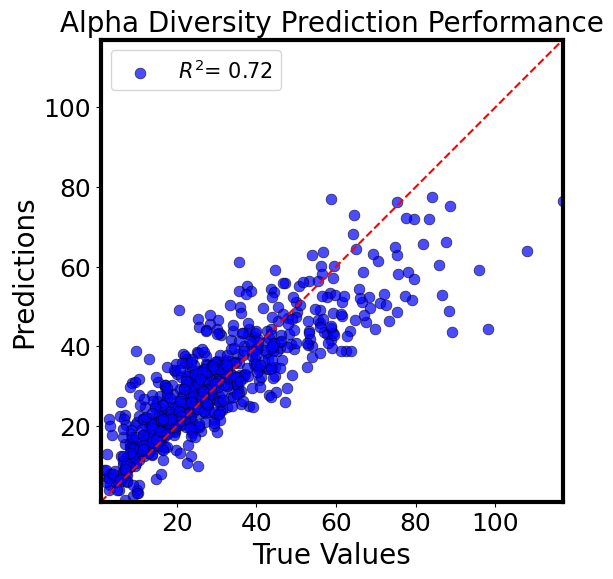

In [15]:
# === Train a regression model on the latent space ===
# === Define a simple MLP for regression ===
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# === Train a regression model on the latent space ===
from sklearn.model_selection import train_test_split

# Split latent representations + targets
X_train, X_test, y_train, y_test = train_test_split(
    torch.tensor(latent_repr, dtype=torch.float32).to(device),
    alpha_diversity_tensor,
    test_size=0.2
)

regressor = MLPRegressor(input_dim=latent_repr.shape[1], output_dim=alpha_diversity_tensor.shape[1]).to(device)
reg_optimizer = optim.Adam(regressor.parameters(), lr=1e-3)
reg_criterion = nn.MSELoss()

# Wrap data into DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
regressor.train()
for epoch in range(50):
    running_loss = 0
    for x_batch, y_batch in train_loader:
        reg_optimizer.zero_grad()
        preds = regressor(x_batch)
        loss = reg_criterion(preds, y_batch)
        loss.backward()
        reg_optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1:03d} | Regression Loss: {running_loss:.4f}")

# === Evaluate the regression model === #
regressor.eval()
with torch.no_grad():
    preds = regressor(X_test)
    test_loss = reg_criterion(preds, y_test).item()
    print(f"\nTest MSE: {test_loss:.4f}")

    # Optional: compute R^2 per species
    from sklearn.metrics import r2_score
    r2 = r2_score(y_test.cpu().numpy(), preds.cpu().numpy(), multioutput='raw_values')
    print(f"R² per species:\n{r2}")
    print(f"Mean R²: {r2.mean():.4f}")
# === Visualize the regression results ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test.cpu().numpy(), preds.cpu().numpy(), alpha=0.7, c='blue', edgecolors='k', s=60, linewidth=0.5)
plt.title("Alpha Diversity Prediction Performance")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.gca().set_aspect('equal', adjustable='box')
plt.legend([f'$R^2$= {r2.mean():.2f}'], loc='upper left')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.savefig("alpha_diversity_prediction_performance.png", dpi=300, bbox_inches='tight')
plt.show()